# Lab 11 - Job Scheduling

Information on group members:

1) 148257, Daniel Jankowski <br>
2) Student ID, Name and last name

In [225]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import colorsys
from typing import Dict, List
import random

1) Your task is to propose a few 3-5 simple heuristics for solving Flow-shop scheduling problems. When the number of machines equals 2, you can compare your heuristics with Johnson's algorithm (the implementation is straightforward).
 - Consider no due times or release times (hence \beta = empty). 
 - Consider the number of machines (e.g., from 2 to 10) and jobs (e.g., from 5 to 100) as the main parameters for your experimental setting. 
 - Within each setting, generate 20 random problem instances, i.e., processing times for the jobs. 
 - Perform the experiments and average the results (report the results). As the optimization criterion, consider the max completion time. 
 - Compare your heuristics and derive conclusions. 
 - For some experimental settings, plot example schedules on Gantt charts. 

In [218]:
N = 4 # number of jobs
M = 2 # number of machines
P = dict()
P[1] = [1,2]
P[2] = [2,1]
P[3] = [2,2]
P[4] = [2,3] # processing times

In [219]:
def johnson(n, m, p):
    n1 = dict()
    n2 = dict()
    for job, times in p.items():
        if times[0] < times[1]:
            n1[job] = times
        else:
            n2[job] = times
    n1 = {k: v for k, v in sorted(n1.items(), key=lambda item: item[1][0])}
    n2 = {k: v for k, v in sorted(n2.items(), key=lambda item: item[1][1], reverse=True)}
    merged = n1 | n2

    schedule = dict()
    schedule["job"] = []
    schedule["Start"] = []
    schedule["Finish"] = []
    schedule["machine"] = []


    first_machine_in_time = 0
    second_machine_in_time = 0
    for inx, (job, times) in enumerate(merged.items()):
        schedule["job"].append(job)
        schedule["Start"].append(first_machine_in_time)
        schedule["Finish"].append(first_machine_in_time+times[0])
        schedule["machine"].append(1)
        first_machine_in_time = schedule["Finish"][-1]

        schedule["job"].append(job)
        schedule["Start"].append(max(second_machine_in_time, schedule["Finish"][-1]))
        schedule["Finish"].append(schedule["Start"][-1]+times[1])
        schedule["machine"].append(2)
        second_machine_in_time = schedule["Finish"][-1]
    return pd.DataFrame.from_dict(schedule)


In [220]:
schedule = johnson(N, M, P)

In [221]:
schedule

,job,Start,Finish,machine
0,1,0,1,1
1,1,1,3,2
2,4,1,3,1
3,4,3,6,2
4,3,3,5,1
5,3,6,8,2
6,2,5,7,1
7,2,8,9,2


In [222]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    


    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    # if verbose:
    #     print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

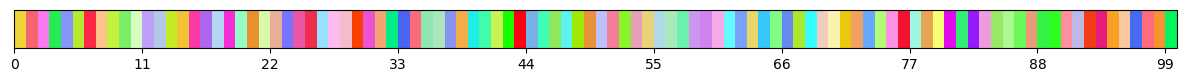

In [110]:
tasks_colors = rand_cmap(nlabels = 100, verbose = True, type="bright", first_color_black=False)

In [223]:
def draw_schedule(schedule: pd.DataFrame, title: str="", color_map=tasks_colors) -> None:


    n_machines = schedule['machine'].max()
    n_tasks = schedule['job'].max()

    fig, gnt = plt.subplots()
    gnt.set_xlim(0, schedule['Finish'].max())
    gnt.set_ylim(0, n_machines)
    gnt.set_xlabel("Processing time")
    gnt.set_ylabel("Machine")

    bar_y_pos = n_machines * 2.5
    for machine in range(1, n_machines+1):
        machine_schedule = schedule[schedule['machine'] == machine]
        task_bars = []
        colors_bars = []
        jobs_name_list = machine_schedule['job'].tolist()
        for _, row in machine_schedule.iterrows():
            task_start = row['Start']
            task_duration = row["Finish"] - row['Start']
            task_bars.append((task_start, task_duration))
            colors_bars.append(color_map(row['job']-1))
        # print(colors_bars)
        gnt.broken_barh(xranges=task_bars, yrange=(bar_y_pos, 1), facecolors=(colors_bars))
        for inx, (x1, x2) in enumerate(task_bars):
            gnt.text(x=x1 + x2/2,
            y=bar_y_pos + 0.5,
            s="J"+str(jobs_name_list[inx]),
            ha='center',
            va='center',
            color="black")
        bar_y_pos -= 1.0
        
    gnt.grid(True)    
    gnt.set_title(title) 
    gnt.set_yticks(np.arange(2.5, 2.5 * n_machines*2, 5))
    # gnt.set_yticklabels([machine for machine in range(n_machines, 0, -1)])

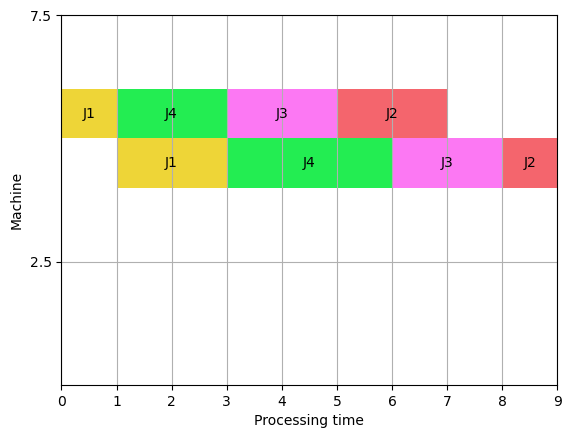

In [224]:
draw_schedule(schedule)

# Datasets #

## Generating random instances of the problem ##

In [231]:
def generate_random_instance(n: int, m: int, max_proc_time: int=10) -> Dict[int, List[int]]:
    P = dict()
    for task in range(1, n+1):
        P[task] = random.sample(range(1, max_proc_time+1), m)
    return P

## Small datasets ##

In [227]:
small_datasets = []
N = [5,10,15] # experiment fo 5,10,15 tasks
M = [2,3,4] # experiment for 2,3,4 machines

i = 20

for n, m in zip(N, M):
    for _ in range(i):
        p = generate_random_instance(n, m)
        small_datasets.append((n, m, p))

## Medium datasets ##

In [232]:
medium_datasets = []
N = [20,30,50] # experiment for 20, 30, 50 tasks
M = [5,6,7] # experiment for 5,6,7 machines

i = 20

for n, m in zip(N, M):
    for _ in range(i):
        p = generate_random_instance(n, m, max_proc_time=15)
        medium_datasets.append((n, m, p))

## Large datasets ##

In [234]:
large_datasets = []
N = [60,75,100] # experiment for 60,75,100 tasks
M = [8,9,10] # experiment for 8,9,10 machines

i = 20

for n, m in zip(N, M):
    for _ in range(i):
        p = generate_random_instance(n, m, max_proc_time=25)
        large_datasets.append((n, m, p))

# Longest total time first #

For each task compute its total processing time. Sort tasks desceding by computed total time. Perform tasks sequentially.

In [237]:
def LTTF(n: int, m: int, P: Dict[int, List[int]]) -> pd.DataFrame:
    
    sorted_jobs = {k: v for k, v in sorted(P.items(), key=lambda x: sum(x[1]), reverse=True)}
    schedule = dict()
    schedule["job"] = []
    schedule["Start"] = []
    schedule["Finish"] = []
    schedule["machine"] = []

    machines_in_times = [0 for machine in range(m)]
    for inx, (job, task_times) in enumerate(sorted_jobs.items()):
        # we can setup first machine times, becuase it is independent
        schedule["job"].append(job)
        schedule["Start"].append(machines_in_times[0]) # machines_in_times[0] of actual in_time for first machine
        schedule["Finish"].append(schedule["Start"][-1] + task_times[0])
        schedule["machine"].append(1)
        machines_in_times[0] = schedule["Finish"][-1]        

        # iterate over the rest machines. Each machine is dependent on the previous one
        for machine in range (1, len(task_times)):
            schedule["job"].append(job)
            schedule["Start"].append(max(machines_in_times[machine], schedule["Finish"][-1]))
            schedule["Finish"].append(schedule["Start"][-1] + task_times[machine])
            schedule["machine"].append(machine+1)
            machines_in_times[machine] = schedule["Finish"][-1]
    return pd.DataFrame.from_dict(schedule), schedule["Finish"][-1]
        
        

## Performance ##

### Small dataset ###

In [248]:
results = np.zeros(shape=(60,))
for inx, set in enumerate(small_datasets):
    n, m, p = set
    results[inx] = LTTF(n,m,p)[1]

set_1_mean = np.mean(results[:20])
set_2_mean = np.mean(results[20:40])
set_3_mean = np.mean(results[40:])

print("Average Cmax for 5 tasks and 2 machines: ", set_1_mean)
print("Average Cmax for 10 tasks and 3 machines: ", set_2_mean)
print("Average Cmax for 15 tasks and 4 machines: ", set_3_mean)

small_means = [set_1_mean, set_2_mean, set_3_mean]

Average Cmax for 5 tasks and 2 machines:  37.7
Average Cmax for 10 tasks and 3 machines:  81.4
Average Cmax for 15 tasks and 4 machines:  120.5


### Medium dataset ###

In [251]:
results = np.zeros(shape=(60,))
for inx, set in enumerate(medium_datasets):
    n, m, p = set
    results[inx] = LTTF(n,m,p)[1]

set_1_mean = np.mean(results[:20])
set_2_mean = np.mean(results[20:40])
set_3_mean = np.mean(results[40:])

print("Average Cmax for 20 tasks and 5 machines: ", set_1_mean)
print("Average Cmax for 30 tasks and 6 machines: ", set_2_mean)
print("Average Cmax for 50 tasks and 7 machines: ", set_3_mean)

medium_means = [set_1_mean, set_2_mean, set_3_mean]

Average Cmax for 20 tasks and 5 machines:  244.0
Average Cmax for 30 tasks and 6 machines:  354.55
Average Cmax for 50 tasks and 7 machines:  555.4


### Large dataset ###

In [252]:
results = np.zeros(shape=(60,))
for inx, set in enumerate(large_datasets):
    n, m, p = set
    results[inx] = LTTF(n,m,p)[1]

set_1_mean = np.mean(results[:20])
set_2_mean = np.mean(results[20:40])
set_3_mean = np.mean(results[40:])

print("Average Cmax for 60 tasks and 8 machines: ", set_1_mean)
print("Average Cmax for 75 tasks and 9 machines: ", set_2_mean)
print("Average Cmax for 100 tasks and 10 machines: ", set_3_mean)

large_means = [set_1_mean, set_2_mean, set_3_mean]

Average Cmax for 60 tasks and 8 machines:  1082.35
Average Cmax for 75 tasks and 9 machines:  1337.75
Average Cmax for 100 tasks and 10 machines:  1737.15


In [253]:
lttf_results = small_means + medium_means + large_means # save results for future comparison

# Shortest total time first #

In [254]:
def STTF(n: int, m: int, P: Dict[int, List[int]]) -> pd.DataFrame:
    
    sorted_jobs = {k: v for k, v in sorted(P.items(), key=lambda x: sum(x[1]))}
    schedule = dict()
    schedule["job"] = []
    schedule["Start"] = []
    schedule["Finish"] = []
    schedule["machine"] = []

    machines_in_times = [0 for machine in range(m)]
    for inx, (job, task_times) in enumerate(sorted_jobs.items()):
        # we can setup first machine times, becuase it is independent
        schedule["job"].append(job)
        schedule["Start"].append(machines_in_times[0]) # machines_in_times[0] of actual in_time for first machine
        schedule["Finish"].append(schedule["Start"][-1] + task_times[0])
        schedule["machine"].append(1)
        machines_in_times[0] = schedule["Finish"][-1]        

        # iterate over the rest machines. Each machine is dependent on the previous one
        for machine in range (1, len(task_times)):
            schedule["job"].append(job)
            schedule["Start"].append(max(machines_in_times[machine], schedule["Finish"][-1]))
            schedule["Finish"].append(schedule["Start"][-1] + task_times[machine])
            schedule["machine"].append(machine+1)
            machines_in_times[machine] = schedule["Finish"][-1]
    return pd.DataFrame.from_dict(schedule), schedule["Finish"][-1]

## Performance ##

In [272]:
results = np.zeros(shape=(60,))
for inx, set in enumerate(small_datasets):
    n, m, p = set
    results[inx] = STTF(n,m,p)[1]

set_1_mean = np.mean(results[:20])
set_2_mean = np.mean(results[20:40])
set_3_mean = np.mean(results[40:])

print("Average Cmax for 5 tasks and 2 machines: ", set_1_mean)
print("Average Cmax for 10 tasks and 3 machines: ", set_2_mean)
print("Average Cmax for 15 tasks and 4 machines: ", set_3_mean)

small_means = [set_1_mean, set_2_mean, set_3_mean]

Average Cmax for 5 tasks and 2 machines:  38.5
Average Cmax for 10 tasks and 3 machines:  79.4
Average Cmax for 15 tasks and 4 machines:  120.2


In [273]:
results = np.zeros(shape=(60,))
for inx, set in enumerate(medium_datasets):
    n, m, p = set
    results[inx] = STTF(n,m,p)[1]

set_1_mean = np.mean(results[:20])
set_2_mean = np.mean(results[20:40])
set_3_mean = np.mean(results[40:])

print("Average Cmax for 20 tasks and 5 machines: ", set_1_mean)
print("Average Cmax for 30 tasks and 6 machines: ", set_2_mean)
print("Average Cmax for 50 tasks and 7 machines: ", set_3_mean)

medium_means = [set_1_mean, set_2_mean, set_3_mean]

Average Cmax for 20 tasks and 5 machines:  236.7
Average Cmax for 30 tasks and 6 machines:  352.05
Average Cmax for 50 tasks and 7 machines:  554.9


In [274]:
results = np.zeros(shape=(60,))
for inx, set in enumerate(large_datasets):
    n, m, p = set
    results[inx] = STTF(n,m,p)[1]

set_1_mean = np.mean(results[:20])
set_2_mean = np.mean(results[20:40])
set_3_mean = np.mean(results[40:])

print("Average Cmax for 60 tasks and 8 machines: ", set_1_mean)
print("Average Cmax for 75 tasks and 9 machines: ", set_2_mean)
print("Average Cmax for 100 tasks and 10 machines: ", set_3_mean)

large_means = [set_1_mean, set_2_mean, set_3_mean]

Average Cmax for 60 tasks and 8 machines:  1084.4
Average Cmax for 75 tasks and 9 machines:  1338.2
Average Cmax for 100 tasks and 10 machines:  1740.0


In [275]:
sttf_results = small_means + medium_means + large_means # save results for future comparison

# Highest standard deviation first #


In [264]:
def HSDF(n: int, m: int, P: Dict[int, List[int]]) -> pd.DataFrame:
    
    sorted_jobs = {k: v for k, v in sorted(P.items(), key=lambda x: np.std(x[1]), reverse=True)}
    schedule = dict()
    schedule["job"] = []
    schedule["Start"] = []
    schedule["Finish"] = []
    schedule["machine"] = []

    machines_in_times = [0 for machine in range(m)]
    for inx, (job, task_times) in enumerate(sorted_jobs.items()):
        # we can setup first machine times, becuase it is independent
        schedule["job"].append(job)
        schedule["Start"].append(machines_in_times[0]) # machines_in_times[0] of actual in_time for first machine
        schedule["Finish"].append(schedule["Start"][-1] + task_times[0])
        schedule["machine"].append(1)
        machines_in_times[0] = schedule["Finish"][-1]        

        # iterate over the rest machines. Each machine is dependent on the previous one
        for machine in range (1, len(task_times)):
            schedule["job"].append(job)
            schedule["Start"].append(max(machines_in_times[machine], schedule["Finish"][-1]))
            schedule["Finish"].append(schedule["Start"][-1] + task_times[machine])
            schedule["machine"].append(machine+1)
            machines_in_times[machine] = schedule["Finish"][-1]
    return pd.DataFrame.from_dict(schedule), schedule["Finish"][-1]

In [259]:
results = np.zeros(shape=(60,))
for inx, set in enumerate(small_datasets):
    n, m, p = set
    results[inx] = HSDF(n,m,p)[1]

set_1_mean = np.mean(results[:20])
set_2_mean = np.mean(results[20:40])
set_3_mean = np.mean(results[40:])

print("Average Cmax for 5 tasks and 2 machines: ", set_1_mean)
print("Average Cmax for 10 tasks and 3 machines: ", set_2_mean)
print("Average Cmax for 15 tasks and 4 machines: ", set_3_mean)

small_means = [set_1_mean, set_2_mean, set_3_mean]

Average Cmax for 5 tasks and 2 machines:  37.95
Average Cmax for 10 tasks and 3 machines:  80.9
Average Cmax for 15 tasks and 4 machines:  118.7


In [260]:
results = np.zeros(shape=(60,))
for inx, set in enumerate(medium_datasets):
    n, m, p = set
    results[inx] = HSDF(n,m,p)[1]

set_1_mean = np.mean(results[:20])
set_2_mean = np.mean(results[20:40])
set_3_mean = np.mean(results[40:])

print("Average Cmax for 20 tasks and 5 machines: ", set_1_mean)
print("Average Cmax for 30 tasks and 6 machines: ", set_2_mean)
print("Average Cmax for 50 tasks and 7 machines: ", set_3_mean)

medium_means = [set_1_mean, set_2_mean, set_3_mean]

Average Cmax for 20 tasks and 5 machines:  238.55
Average Cmax for 30 tasks and 6 machines:  352.3
Average Cmax for 50 tasks and 7 machines:  558.65


In [261]:
results = np.zeros(shape=(60,))
for inx, set in enumerate(large_datasets):
    n, m, p = set
    results[inx] = HSDF(n,m,p)[1]

set_1_mean = np.mean(results[:20])
set_2_mean = np.mean(results[20:40])
set_3_mean = np.mean(results[40:])

print("Average Cmax for 60 tasks and 8 machines: ", set_1_mean)
print("Average Cmax for 75 tasks and 9 machines: ", set_2_mean)
print("Average Cmax for 100 tasks and 10 machines: ", set_3_mean)

large_means = [set_1_mean, set_2_mean, set_3_mean]

Average Cmax for 60 tasks and 8 machines:  1088.2
Average Cmax for 75 tasks and 9 machines:  1333.75
Average Cmax for 100 tasks and 10 machines:  1750.15


In [265]:
hsdf_results = small_means + medium_means + large_means

# Lowest standard deviation first #

In [263]:
def LSDF(n: int, m: int, P: Dict[int, List[int]]) -> pd.DataFrame:
    
    sorted_jobs = {k: v for k, v in sorted(P.items(), key=lambda x: np.std(x[1]))}
    schedule = dict()
    schedule["job"] = []
    schedule["Start"] = []
    schedule["Finish"] = []
    schedule["machine"] = []

    machines_in_times = [0 for machine in range(m)]
    for inx, (job, task_times) in enumerate(sorted_jobs.items()):
        # we can setup first machine times, becuase it is independent
        schedule["job"].append(job)
        schedule["Start"].append(machines_in_times[0]) # machines_in_times[0] of actual in_time for first machine
        schedule["Finish"].append(schedule["Start"][-1] + task_times[0])
        schedule["machine"].append(1)
        machines_in_times[0] = schedule["Finish"][-1]        

        # iterate over the rest machines. Each machine is dependent on the previous one
        for machine in range (1, len(task_times)):
            schedule["job"].append(job)
            schedule["Start"].append(max(machines_in_times[machine], schedule["Finish"][-1]))
            schedule["Finish"].append(schedule["Start"][-1] + task_times[machine])
            schedule["machine"].append(machine+1)
            machines_in_times[machine] = schedule["Finish"][-1]
    return pd.DataFrame.from_dict(schedule), schedule["Finish"][-1]

In [266]:
results = np.zeros(shape=(60,))
for inx, set in enumerate(small_datasets):
    n, m, p = set
    results[inx] = LSDF(n,m,p)[1]

set_1_mean = np.mean(results[:20])
set_2_mean = np.mean(results[20:40])
set_3_mean = np.mean(results[40:])

print("Average Cmax for 5 tasks and 2 machines: ", set_1_mean)
print("Average Cmax for 10 tasks and 3 machines: ", set_2_mean)
print("Average Cmax for 15 tasks and 4 machines: ", set_3_mean)

small_means = [set_1_mean, set_2_mean, set_3_mean]

Average Cmax for 5 tasks and 2 machines:  38.55
Average Cmax for 10 tasks and 3 machines:  77.1
Average Cmax for 15 tasks and 4 machines:  118.35


In [267]:
results = np.zeros(shape=(60,))
for inx, set in enumerate(medium_datasets):
    n, m, p = set
    results[inx] = LSDF(n,m,p)[1]

set_1_mean = np.mean(results[:20])
set_2_mean = np.mean(results[20:40])
set_3_mean = np.mean(results[40:])

print("Average Cmax for 20 tasks and 5 machines: ", set_1_mean)
print("Average Cmax for 30 tasks and 6 machines: ", set_2_mean)
print("Average Cmax for 50 tasks and 7 machines: ", set_3_mean)

medium_means = [set_1_mean, set_2_mean, set_3_mean]

Average Cmax for 20 tasks and 5 machines:  240.25
Average Cmax for 30 tasks and 6 machines:  345.5
Average Cmax for 50 tasks and 7 machines:  562.85


In [268]:
results = np.zeros(shape=(60,))
for inx, set in enumerate(large_datasets):
    n, m, p = set
    results[inx] = LSDF(n,m,p)[1]

set_1_mean = np.mean(results[:20])
set_2_mean = np.mean(results[20:40])
set_3_mean = np.mean(results[40:])

print("Average Cmax for 60 tasks and 8 machines: ", set_1_mean)
print("Average Cmax for 75 tasks and 9 machines: ", set_2_mean)
print("Average Cmax for 100 tasks and 10 machines: ", set_3_mean)

large_means = [set_1_mean, set_2_mean, set_3_mean]

Average Cmax for 60 tasks and 8 machines:  1090.45
Average Cmax for 75 tasks and 9 machines:  1343.05
Average Cmax for 100 tasks and 10 machines:  1739.65


In [269]:
lsdf_results = small_means + medium_means + large_means


# Comparison #

In [276]:
results = dict()
results['Machines'] = [2,3,4,5,6,7,8,9,10]
results['Tasks'] = [5,10,15,20,30,50,60,75,100]
results['LTTF'] = lttf_results
results['STTF'] = sttf_results
results['HSDF'] = hsdf_results
results['LSDF'] = lsdf_results

df = pd.DataFrame.from_dict(results)


In [277]:
df

,Machines,Tasks,LTTF,STTF,HSDF,LSDF
0,2,5,37.70,38.50,37.95,38.55
1,3,10,81.40,79.40,80.90,77.10
2,4,15,120.50,120.20,118.70,118.35
3,5,20,244.00,236.70,238.55,240.25
4,6,30,354.55,352.05,352.30,345.50
5,7,50,555.40,554.90,558.65,562.85
6,8,60,1082.35,1084.40,1088.20,1090.45
7,9,75,1337.75,1338.20,1333.75,1343.05
8,10,100,1737.15,1740.00,1750.15,1739.65
